# Bonus task - LSTM implementation

In [45]:
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix

from utils import read_datasets, get_score, plot_anomalies
import numpy as np

## Read datasets

In [46]:
scaled_df1, train_y1, scaled_df2, train_y2, scaled_test_df, y = read_datasets()

## Set network parameters

In [47]:
# Set parameters
# torch.cuda.set_device(0)

input_size = scaled_test_df.shape[1]

# Data params
batch_size = scaled_df1.shape[0]

# LSTM reads in one timestep at a time.
lstm_input_size = 1

# size of hidden layers
h1 = 32
output_dim = 1
num_layers = 3
learning_rate = 1e-3
num_epochs = 100
dtype = torch.float

## Convert datasets to Tensors

In [48]:
# make training and test sets in torch
X_train = torch.from_numpy(scaled_df1.to_numpy()).type(torch.Tensor)
X_val = torch.from_numpy(scaled_df2.to_numpy()).type(torch.Tensor)
X_test = torch.from_numpy(scaled_test_df.to_numpy()).type(torch.Tensor)
y_train = torch.from_numpy(train_y1.to_numpy()).type(torch.Tensor).view(-1)
y_val = torch.from_numpy(train_y2.to_numpy()).type(torch.Tensor).view(-1)
y_test = torch.from_numpy(y.to_numpy()).type(torch.Tensor).view(-1)

X_train = X_train.view(scaled_df1.shape[1], scaled_df1.shape[0])
X_val = X_val.view(scaled_df2.shape[1], scaled_df2.shape[0])
X_test = X_test.view(scaled_test_df.shape[1], scaled_test_df.shape[0])

## Build LSTM model

In [49]:
#####################
# Build model
#####################


# Define model
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                 num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self, x):
        return (torch.zeros(self.num_layers, x.shape[0], self.hidden_dim),
                torch.zeros(self.num_layers, x.shape[0], self.hidden_dim))
    
    # forward pass through LSTM layer
    def forward(self, x):
        self.hidden = self.init_hidden(x)

        lstm_out, self.hidden = self.lstm(x.view(x.shape[0], x.shape[1], -1))

        y_pred = self.linear(lstm_out[-1].view(x.shape[1], -1))
        return y_pred.view(-1)



## Create LSTM

In [50]:
model = LSTM(lstm_input_size, h1, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(reduction='sum')

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train model

In [52]:
# Train model

hist = np.zeros(num_epochs)
prediction_list = []
prediction_list_val = []

for epoch in range(num_epochs):
    # Forward pass
    y_pred = model(X_train)

    loss = loss_fn(y_pred, y_train)
    # if epoch % 100 == 0:
    #     print("Epoch ", epoch, "MSE: ", loss.item())
    hist[epoch] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()
    running_loss_train = loss.item()
    print('Epoch {} Train Loss:{}'.format(epoch + 1, running_loss_train))


Epoch 1 Train Loss:304.747314453125
Epoch 2 Train Loss:248.53814697265625
Epoch 3 Train Loss:197.35670471191406
Epoch 4 Train Loss:151.18702697753906
Epoch 5 Train Loss:110.17108917236328
Epoch 6 Train Loss:74.61627197265625
Epoch 7 Train Loss:45.044151306152344
Epoch 8 Train Loss:22.200634002685547
Epoch 9 Train Loss:7.015934467315674
Epoch 10 Train Loss:0.39790624380111694
Epoch 11 Train Loss:2.5572609901428223
Epoch 12 Train Loss:11.44882583618164
Epoch 13 Train Loss:21.751367568969727
Epoch 14 Train Loss:28.158159255981445
Epoch 15 Train Loss:28.891687393188477
Epoch 16 Train Loss:25.121213912963867
Epoch 17 Train Loss:19.04611587524414
Epoch 18 Train Loss:12.642169952392578
Epoch 19 Train Loss:7.194157600402832
Epoch 20 Train Loss:3.289409637451172
Epoch 21 Train Loss:0.9999744296073914
Epoch 22 Train Loss:0.0945608839392662
Epoch 23 Train Loss:0.20935598015785217
Epoch 24 Train Loss:0.9608027338981628
Epoch 25 Train Loss:2.0085415840148926
Epoch 26 Train Loss:3.0837039947509766
E

## Plot precision and recall for different threshold values

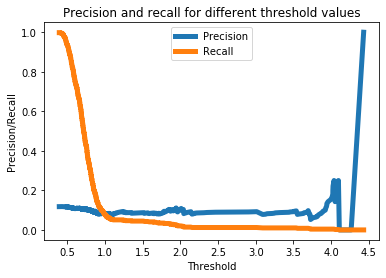

In [91]:
# Plot preds and performance
# base on https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098

valid_x_predictions = model(X_val)
mse = np.mean(np.power(X_val.detach().numpy() - valid_x_predictions.detach().numpy(), 2), axis=0)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                         'True_class': y_val == 1})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision", linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall", linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()
# plt.savefig('plots/lstm/pre_rec.png', bbox_inches='tight')


## Plot reconstruction error for the two classes

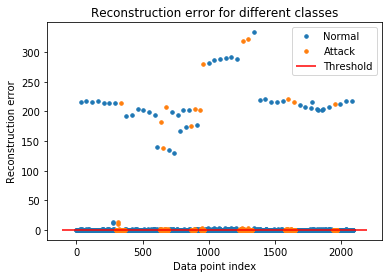

In [92]:
# based on https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098
threshold = 1


test_x_predictions = model(X_test)
mse = np.mean(np.power(X_test.detach().numpy() - test_x_predictions.detach().numpy(), 2), axis=0)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})
error_df_test = error_df_test.reset_index()

groups = error_df_test.groupby('True_class')

fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()
# plt.savefig('plots/lstm/diff_classes.png', bbox_inches='tight')



## Scores

In [83]:
predicted_anomalies = np.where(error_df.Reconstruction_error.values > threshold)[0]
true_anomalies = np.where(error_df.True_class.values > 0)[0]
[tp, fp, fn, tn, tpr, tnr, Sttd, Scm, S] = get_score(predicted_anomalies, true_anomalies, y=y)
print("TP: {0}, FP: {1}, TPR: {2}, TNR: {3}".format(tp, fp, tpr, tnr))
print("Sttd: {0}, Scm: {1}, S: {2}".format(Sttd, Scm, S))


TP: 38, FP: 432, TPR: 0.07723577235772358, TNR: 0.7294927989981215
Sttd: 0.7161248122077615, Scm: 0.40336428567792254, S: 0.559744548942842
